Coded by Lujia Zhong @lujiazho<br>
Reference: https://github.com/microsoft/Swin-Transformer

<center>
    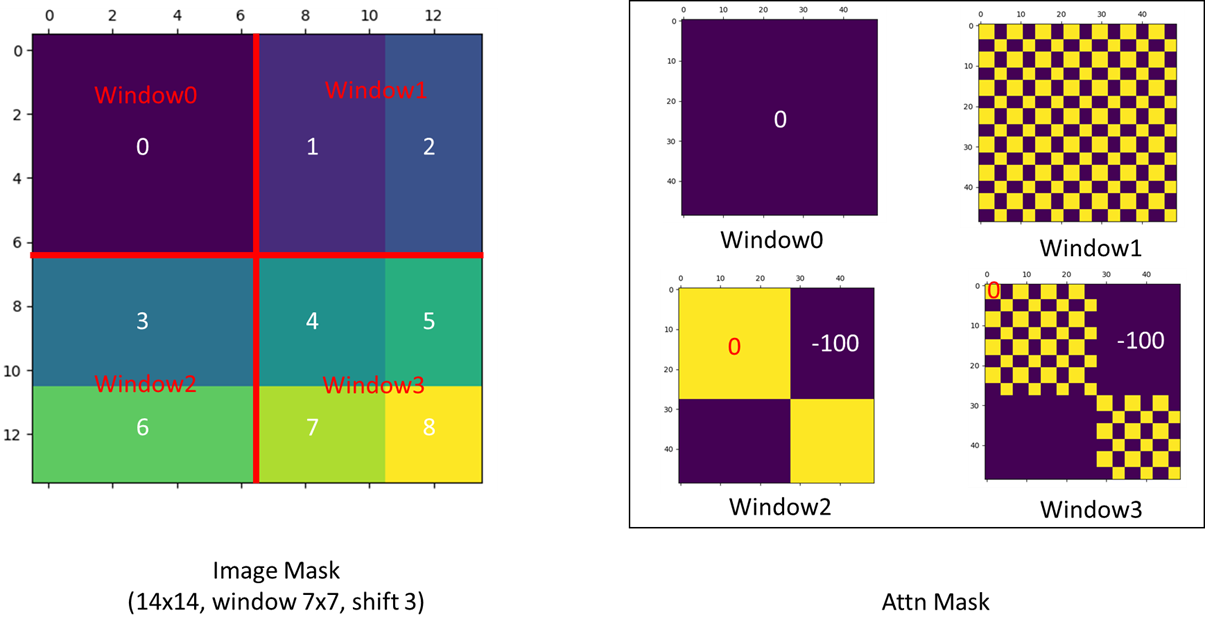
</center>

In [1]:
import time
import numpy as np
import torch
from torch import nn
from torch.nn import MSELoss, Dropout, Softmax, Linear, Conv2d, LayerNorm, GELU

# from timm: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor

# from timm: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        # in dropout, some nodes are deactivated in a batch by set some inputs to zero
        # in droppath, some inputs in a batch are all set to zero to deactivate this whole path
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


class MLP(nn.Module):
    def __init__(self, config, in_features):
        super().__init__()
        
        hidden_features = int(in_features * config.mlp_ratio)
        self.fc1 = Linear(in_features, hidden_features)
        self.act = GELU()
        self.fc2 = Linear(hidden_features, in_features)
        self.dropout = Dropout(config.dropout_rate)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        
        return x

class WindowAttention(nn.Module):
    def __init__(self, config, in_c, num_heads):
        super().__init__()

        self.window_size = config.window_size
        self.num_heads = num_heads
        self.head_dim = in_c // num_heads
        self.scale = self.head_dim ** -0.5

        # learnable relative position bias table: [13*13, heads]
        self.rpb_table = nn.Parameter(torch.randn((2*self.window_size-1)**2, num_heads))

        # fixed relative position index
        coords_h = coords_w = torch.arange(self.window_size)                      # tensor([0, 1, 2, 3, 4, 5, 6])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij')) # [2, 7, 7]
        coords_flatten = torch.flatten(coords, 1)                                 # [2, 7*7]
        # [2, 7*7, 1] - [2, 1, 7*7] -> [2, 7*7, 7*7]
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()           # [7*7, 7*7, 2]
        # change range from (-6, 6) to (0, 12) in relative_coords
        relative_coords += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)                         # [7*7, 7*7]
        self.register_buffer("relative_position_index", relative_position_index)

        # Q, K, V        
        self.query = Linear(in_c, in_c)
        self.key = Linear(in_c, in_c)
        self.value = Linear(in_c, in_c)
        
        self.softmax = Softmax(dim=-1)
        self.attn_drop = Dropout(config.dropout_rate)
        
        self.proj = Linear(in_c, in_c)
        self.proj_drop = Dropout(config.dropout_rate)

    def transpose_for_scores(self, x):
        new_x_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, x, mask=None):
        # [B*num_wins, 7*7, C]
        B_, N, C = x.shape
        
        mixed_query_layer = self.query(x)        # [num_wins*B, 7*7, C]
        mixed_key_layer = self.key(x)            # [num_wins*B, 7*7, C]
        mixed_value_layer = self.value(x)        # [num_wins*B, 7*7, C]
        
        query_layer = self.transpose_for_scores(mixed_query_layer)  # [num_wins*B, heads, 7*7, C/heads]
        key_layer = self.transpose_for_scores(mixed_key_layer)      # [num_wins*B, heads, 7*7, C/heads]
        value_layer = self.transpose_for_scores(mixed_value_layer)  # [num_wins*B, heads, 7*7, C/heads]
        
        attn = torch.matmul(query_layer, key_layer.transpose(-2, -1)) * self.scale
        
        relative_position_bias = self.rpb_table[self.relative_position_index]         # [7*7, 7*7, heads]
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous() # [heads, 7*7, 7*7]
        # [B*num_wins, heads, 7*7, 7*7] + [1, heads, 7*7, 7*7]
        attn = attn + relative_position_bias.unsqueeze(0)

        # for shifted windows. Mask keeps the same for any batch and any heads
        if mask is not None:
            num_wins = mask.shape[0]
            # [B, num_wins, heads, 7*7, 7*7] + [1, num_Wins, 1, 7*7, 7*7].
            attn = attn.view(B_ // num_wins, num_wins, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            # [B, num_wins, heads, 7*7, 7*7] -> [B*num_wins, heads, 7*7, 7*7]
            attn = attn.view(-1, self.num_heads, N, N)
        
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        context_layer = torch.matmul(attn, value_layer)                   # [B*num_wins, heads, 7*7, C/heads]
        context_layer = context_layer.transpose(1, 2).reshape(B_, N, C)   # [B*num_wins, 7*7, C]
        attention_output = self.proj(context_layer)                       # [B*num_wins, 7*7, C]
        attention_output = self.proj_drop(attention_output)
        
        return attention_output

class SwinTransformerBlock(nn.Module):
    def __init__(self, config, in_c, input_resolution, num_heads, shift_size=0, drop_path=0.):
        super().__init__()
        
        self.window_size = config.window_size
        self.shift_size = shift_size # for SW-MSA

        # stop shift when window_size is larger than input size
        if input_resolution <= self.window_size:
            self.shift_size = 0
            self.window_size = input_resolution
            
        assert 0 <= self.shift_size < self.window_size

        # MSA part
        self.norm1 = LayerNorm(in_c)
        self.attn = WindowAttention(config, in_c, num_heads=num_heads)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
        # MLP part
        self.norm2 = LayerNorm(in_c)
        self.mlp = MLP(config, in_features=in_c)

        # attention mask for SW-MSA
        attn_mask = None
        if self.shift_size > 0:
            H = W = input_resolution
            img_mask = torch.zeros((1, H, W, 1)) # mask is the same for any batch
            
            # 9 types of area after shifting
            h_slices = w_slices = (slice(0, -self.window_size),
                                   slice(-self.window_size, -self.shift_size),
                                   slice(-self.shift_size, None))
            # label them from 0 - 8
            for i, h in enumerate(h_slices):
                for j, w in enumerate(w_slices):
                    img_mask[:, h, w, :] = i*3 + j

            # partition them to the same form as inputs
            mask_windows = self.window_partition(img_mask, self.window_size)          # [num_Wins, 7, 7, 1]
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size) # [num_Wins, 7*7]
            # unsqueeze(1): [num_Wins, 1, 7*7]; unsqueeze(2): [num_Wins, 7*7, 1]
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)         # [num_Wins, 7*7, 7*7]
            # fill in real masking data. The -100 would be near 0 after a softmax
            attn_mask = attn_mask.masked_fill(attn_mask != 0, -100.0).masked_fill(attn_mask == 0, 0.0)

        # Buffers are persistent, and can be acquired as parameters in state_dict
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L))

        # MSA part
        h = x
        x = self.norm1(x)
        x = x.view(B, H, W, C) # [B, H, W, C]

        # cyclic shift
        shifted_x = x
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        # partition windows: process all partition windows as batchs
        x_windows = self.window_partition(shifted_x, self.window_size)              # [num_Wins*B, 7, 7, C]
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)      # [num_Wins*B, 7*7, C]

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)                    # [num_Wins*B, 7*7, C]

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C) # [num_Wins*B, 7, 7, C]
        shifted_x = self.window_reverse(attn_windows, self.window_size, H, W)       # [B, H, W, C]

        # reverse cyclic shift
        x = shifted_x
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        
        x = x.view(B, H * W, C) # [B, H*W, C]
        x = h + self.drop_path(x)

        # MLP part
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x + h

        return x
    
    def window_partition(self, x, window_size):
        B, H, W, C = x.shape
        x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
        # x: [B, H/7, 7, W/7, 7, C]
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
        # windows: [B, H/7, 7, W/7, 7, C] -> [B, H/7, W/7, 7, 7, C] -> [num_wins*B, 7, 7, C]
        return windows
    
    def window_reverse(self, windows, window_size, H, W):
        B = int(windows.shape[0] / (H*W/(window_size**2)))
        x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
        # x: [B, H/7, W/7, 7, 7, C]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
        # x: [B, H/7, W/7, 7, 7, C] -> [B, H/7, 7, W/7, 7, C] -> [B, H, W, C]
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        self.reduction = Linear(4 * in_c, 2 * in_c, bias=False)
        self.norm = LayerNorm(4 * in_c)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L))
        assert H % 2 == 0 and W % 2 == 0

        x = x.view(B, H, W, C)

        # 4 parts of inputs are taken with interval=2
        x0 = x[:, 0::2, 0::2, :]  # [B, H/2, W/2, C]
        x1 = x[:, 1::2, 0::2, :]  # [B, H/2, W/2, C]
        x2 = x[:, 0::2, 1::2, :]  # [B, H/2, W/2, C]
        x3 = x[:, 1::2, 1::2, :]  # [B, H/2, W/2, C]
        
        # stack these 4 parts
        x = torch.cat([x0, x1, x2, x3], -1)  # [B, H/2, W/2, 4*C]
        x = x.view(B, -1, 4 * C)             # [B, (H/2)*(W/2), 4*C]

        x = self.norm(x)
        x = self.reduction(x)                # [B, (H/2)*(W/2), 2*C]

        return x


class Stage(nn.Module):
    def __init__(self, config, i_layer, in_c, swin_input_resolution, drop_path=0., downsample=None):
        super().__init__()

        # patch embedding or merging layer
        self.downsample = downsample
        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(config=config, in_c=in_c, 
                                 input_resolution=swin_input_resolution,
                                 num_heads=config.num_heads[i_layer], 
                                 shift_size=config.window_size//2 if i%2 else 0,
                                 drop_path=drop_path[i])
            for i in range(config.depths[i_layer])])

    def forward(self, x):
        
        # [B, H*W, C] -> [B, (H/2)*(W/2), 2*C]
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x) # dimensions keep the same
        
        return x

class PatchEmbed(nn.Module):
    def __init__(self, config, in_c=3):
        super().__init__()
        patch_size = (config.patch_size, config.patch_size)

        self.patch_embeddings = Conv2d(in_c, config.embedding_size, kernel_size=patch_size, stride=patch_size)
        self.norm = LayerNorm(config.embedding_size)

    def forward(self, x):
        # torch.Size([4, 3, 224, 224])
        
        x = self.patch_embeddings(x).flatten(2).transpose(1, 2) # torch.Size([4, 3136, 96])
        x = self.norm(x)                                        # torch.Size([4, 3136, 96])
        
        return x

class SwinTransformer(nn.Module):
    def __init__(self, config, img_size=224, in_channel=3, num_classes=1000):
        super().__init__()
        
        assert img_size % config.patch_size == 0, "invalid combination of img_size and patch_size"
        assert img_size % (config.patch_size*config.window_size) == 0, \
                "invalid combination of img_size, patch_size, and window_size"
        assert num_classes > 0, f"invalid number of classes: {num_classes}"

        num_stages = len(config.depths)
        patches_resolution = img_size // config.patch_size

        '''droppath rate: (if = 0.2)
        (tensor([0.0000, 0.0182]), tensor([0.0364, 0.0545]), ..., tensor([0.1818, 0.2000])) for different stages
        '''
        dpr = torch.linspace(0, config.droppath_rate, sum(config.depths)).split(config.depths)

        # stages part
        self.stages = nn.ModuleList()
        for i_layer in range(num_stages):
            swin_in_c = int(config.embedding_size * 2**i_layer)                   # 96, 192, 384, 768
            conv_in_c = swin_in_c//2                                              #      96, 192, 384
            
            downsample = PatchEmbed(config, in_c=in_channel) if not i_layer else PatchMerging(in_c=conv_in_c)

            stage = Stage(config=config, i_layer=i_layer, in_c=swin_in_c,
                          swin_input_resolution=patches_resolution//(2**i_layer), # 56, 28, 14, 7
                          drop_path=dpr[i_layer], downsample=downsample)
            self.stages.append(stage)

        # classification part
        num_features = int(config.embedding_size * 2 ** (num_stages - 1))         # 768
        self.norm = LayerNorm(num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1) # output size=1 means global average pooling
        self.head = Linear(num_features, num_classes)

    def forward(self, x):
        # torch.Size([4, 3, 224, 224])

        # Swin Architecture
        x = self.stages[0](x)    # torch.Size([4, 3136, 96])
        x = self.stages[1](x)    # torch.Size([4, 784, 192])
        x = self.stages[2](x)    # torch.Size([4, 196, 384])
        x = self.stages[3](x)    # torch.Size([4, 49, 768])
        
        # classification part
        x = self.norm(x)         # torch.Size([4, 49, 768])
        x = self.avgpool(x.transpose(1, 2))  # torch.Size([4, 768, 1])
        x = torch.flatten(x, 1)  # torch.Size([4, 768])        
        x = self.head(x)         # torch.Size([4, 1000])
        
        return x

class ModelConfig:
    def __init__(self, SwinType='Swin-T'):
        self.patch_size = 4
        self.window_size = 7                   # MSA window
        self.mlp_ratio = 4.                    # embedding size ratio in MLP
        self.dropout_rate = 0.                 # dropout rate

        if SwinType == 'Swin-T':               # tiny
            self.droppath_rate = 0.2
            self.embedding_size = 96
            self.depths = [2, 2, 6, 2]
            self.num_heads = [3, 6, 12, 24]
        elif SwinType == 'Swin-S':             # small
            self.droppath_rate = 0.3
            self.embedding_size = 96
            self.depths = [2, 2, 18, 2]
            self.num_heads = [3, 6, 12, 24]
        elif SwinType == 'Swin-B':             # base
            self.droppath_rate = 0.5
            self.embedding_size = 128
            self.depths = [2, 2, 18, 2]
            self.num_heads = [4, 8, 16, 32]
        elif SwinType == 'Swin-L':             # large
            self.droppath_rate = 0.2
            self.embedding_size = 192
            self.depths = [2, 2, 18, 2]
            self.num_heads = [6, 12, 24, 48]

img_size = 224
in_channel = 3
num_classes = 1000

model = SwinTransformer(ModelConfig('Swin-T'), img_size=img_size, in_channel=in_channel, num_classes=num_classes)

In [2]:
optimizer = torch.optim.SGD(model.parameters(),
                                lr=3e-2,
                                momentum=0.9,
                                weight_decay=0)
criterion = MSELoss()

iterarions = 5
begin = time.time()
# Training
for iterarion in range(iterarions):
    x = torch.Tensor(np.random.randn(4, in_channel, img_size, img_size))
    y = torch.Tensor(np.eye(num_classes)[list(map(int, np.random.rand(4)*num_classes))])
    
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    
    if iterarion % 1 == 0:
        print('Iterarion:', '%2d,' % (iterarion + 1), 'loss =', '{:.4f}'.format(loss))

    loss.backward()
    optimizer.step()
print(f"{(time.time() - begin)/iterarions:.4f}s / iterarion")

Iterarion:  1, loss = 0.1790
Iterarion:  2, loss = 0.1225
Iterarion:  3, loss = 0.1025
Iterarion:  4, loss = 0.0837
Iterarion:  5, loss = 0.0708
1.3623s / iterarion
